# A Transfer Learning and Optimized CNN Based Intrusion Detection System for droness. 
**Notebook 1: Data pre-processing**  
Procedures:  
&nbsp; 1): Read the dataset  
&nbsp; 2): Transform the tabular data into images  
&nbsp; 3): Display the transformed images  
&nbsp; 4): Split the training and test set  

## Import libraries

In [9]:
import numpy as np
import pandas as pd
import os
import cv2
import math
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer
from PIL import Image
import warnings
from pickle import load, dump
warnings.filterwarnings("ignore")
print("Done")

Done


## Read the NSL-KDD train dataset
The complete  NSL-KDD dataset is publicly available at:https://www.unb.ca/cic/datasets/nsl.html 


In [2]:
#Read dataset
df=pd.read_csv(r'C:\Users\hadas\Desktop\project\data\NSL-KDD\data25_NSL_KDD.csv')

In [3]:
df

,Unnamed: 0,Src Bytes,Dst Bytes,Urgent,Num Failed Logins,Root Shell,Num Shells,Is Hot Logins,Is Guest Login,Diff Srv Rate,...,pop_3,http_8001,aol,http_2784,harvest,imap4,SF,SH,OTH,Class
0,0,491.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Normal
1,1,146.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.150000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Normal
2,2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.070000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS
3,3,232.000000,8153.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Normal
4,4,199.000000,420.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280434,280434,18.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,U2R
280435,280435,8.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,U2R
280436,280436,0.000000,2072.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.445118,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,U2R
280437,280437,102.286717,530.059439,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,U2R


In [4]:
df=df.drop(['Unnamed: 0'], axis=1)

In [26]:
# The labels of the dataset. "normal" indicates normal patterns,
#and there are four types of attack (DoS, Probe, R2L, U2R )
df.Class.value_counts()

Normal    77054
DoS       53385
R2L       50000
Probe     50000
U2R       50000
Name: Class, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280439 entries, 0 to 280438
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Src Bytes                    280439 non-null  float64
 1   Dst Bytes                    280439 non-null  float64
 2   Urgent                       280439 non-null  float64
 3   Num Failed Logins            280439 non-null  float64
 4   Root Shell                   280439 non-null  float64
 5   Num Shells                   280439 non-null  float64
 6   Is Hot Logins                280439 non-null  float64
 7   Is Guest Login               280439 non-null  float64
 8   Diff Srv Rate                280439 non-null  float64
 9   Srv Diff Host Rate           280439 non-null  float64
 10  Dst Host Same Src Port Rate  280439 non-null  float64
 11  Dst Host Srv Diff Host Rate  280439 non-null  float64
 12  Difficulty Level             280439 non-null  float64
 13 

## Data Transformation
Convert tabular data to images
Procedures:
1. Use quantile transform to transform the original data samples into the scale of [0,255], representing pixel values
2. Generate images for each category (Normal, DoS, Probe, R2L, U2R), the size of each image is 12*11, length 12, width 11, and 1 color channel.

In [10]:
# Transform all features into the scale of [0,1]
numeric_features = ['Src Bytes', 'Dst Bytes', 'Urgent', 'Num Failed Logins',
       'Root Shell', 'Num Shells', 'Is Hot Logins', 'Is Guest Login',
       'Diff Srv Rate', 'Srv Diff Host Rate',
       'Dst Host Same Src Port Rate', 'Dst Host Srv Diff Host Rate',
       'Difficulty Level']
scaler = QuantileTransformer() 
df[numeric_features] = scaler.fit_transform(df[numeric_features])
dump(scaler, open('scaler.pkl', 'wb'))

In [28]:
# Multiply the feature values by 255 to transform them into the scale of [0,255]
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(lambda x: (x*255))

In [29]:
df.describe()

,Src Bytes,Dst Bytes,Urgent,Num Failed Logins,Root Shell,Num Shells,Is Hot Logins,Is Guest Login,Diff Srv Rate,Srv Diff Host Rate,...,ftp,pop_3,http_8001,aol,http_2784,harvest,imap4,SF,SH,OTH
count,280439.000000,280439.000000,280439.000000,280439.000000,280439.000000,280439.000000,280439.000000,280439.000000,280439.000000,280439.000000,...,280439.000000,280439.000000,280439.000000,280439.000000,280439.000000,280439.000000,280439.000000,280439.000000,280439.000000,280439.000000
mean,117.587012,87.317692,2.717313,7.444302,11.857099,5.439805,1.204833,11.750557,59.777140,46.276453,...,15.130644,9.791915,0.005108,0.004646,0.001072,0.006303,0.908729,181.781550,1.126033,0.138584
std,85.846934,100.910178,26.113980,42.595661,53.268322,36.644448,17.466977,53.444281,99.142913,94.249661,...,59.889503,48.955783,1.074352,1.025448,0.489164,1.177856,15.123014,115.203602,16.868984,5.915973
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,127.755255,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,255.000000,0.000000,0.000000
75%,191.195898,190.954136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,193.100601,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,255.000000,0.000000,0.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [30]:
df

,Src Bytes,Dst Bytes,Urgent,Num Failed Logins,Root Shell,Num Shells,Is Hot Logins,Is Guest Login,Diff Srv Rate,Srv Diff Host Rate,...,pop_3,http_8001,aol,http_2784,harvest,imap4,SF,SH,OTH,Class
0,221.237584,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,Normal
1,163.873874,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,231.683026,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,Normal
2,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,220.668168,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS
3,189.399399,243.610190,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,Normal
4,176.891892,191.245091,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,211.606607,...,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280434,113.460961,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,U2R
280435,90.998498,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,255.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,U2R
280436,0.000000,218.498498,0.0,0.0,255.0,0.000000,0.0,0.0,236.146676,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,U2R
280437,152.297491,193.610957,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,U2R


### Generate images for each class

In [33]:
df0=df[df['Class']=='Normal'].drop(['Class'],axis=1)
df1=df[df['Class']=='DoS'].drop(['Class'],axis=1)
df2=df[df['Class']=='Probe'].drop(['Class'],axis=1)
df3=df[df['Class']=='R2L'].drop(['Class'],axis=1)
df4=df[df['Class']=='U2R'].drop(['Class'],axis=1)


In [34]:
df0

,Src Bytes,Dst Bytes,Urgent,Num Failed Logins,Root Shell,Num Shells,Is Hot Logins,Is Guest Login,Diff Srv Rate,Srv Diff Host Rate,...,ftp,pop_3,http_8001,aol,http_2784,harvest,imap4,SF,SH,OTH
0,221.237584,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0
1,163.873874,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,231.683026,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0
3,189.399399,243.610190,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0
4,176.891892,191.245091,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,211.606607,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0
12,200.885886,220.047167,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,224.369369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148506,198.837738,215.180180,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0
148508,199.737237,241.153608,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0
148512,224.461982,186.208709,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0
148513,208.543544,206.617920,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,217.860360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0


In [35]:
# Generate 5*5 images for each class.

dic_class = {"train_NSL-KDD_25/0/":df0,"train_NSL-KDD_25/1/":df1,"train_NSL-KDD_25/2/":df2,"train_NSL-KDD_25/3/":df3, "train_NSL-KDD_25/4/":df4}

for k in dic_class.keys():
    ims = []
    image_path = k
    os.makedirs(image_path)
    for i in range(0, len(dic_class[k])):
        ims=dic_class[k].iloc[i].values
        ims=np.array(ims).reshape(5,5,1)
        array = np.array(ims, dtype=np.uint8)
        array = np.squeeze(array, axis=2)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')

## Split the training and test set 

In [38]:
# Create folders to store images
Train_Dir='./train_NSL-KDD_25/'
Val_Dir='./test_NSL-KDD_25/'
allimgs=[]
for subdir in os.listdir(Train_Dir):
    for filename in os.listdir(os.path.join(Train_Dir,subdir)):
        filepath=os.path.join(Train_Dir,subdir,filename)
        allimgs.append(filepath)
print(len(allimgs)) # Print the total number of images

280439


In [39]:
#split a test set from the dataset, train/test size = 80%/20%
Numbers=len(allimgs)//5 	#size of test set (20%)

def mymovefile(srcfile,dstfile):
    if not os.path.isfile(srcfile):
        print ("%s not exist!"%(srcfile))
    else:
        fpath,fname=os.path.split(dstfile)    
        if not os.path.exists(fpath):
            os.makedirs(fpath)               
        shutil.move(srcfile,dstfile)          
        #print ("move %s -> %s"%(srcfile,dstfile))

In [40]:
# The size of test set
Numbers

56087

In [41]:
# Create the test set
val_imgs=random.sample(allimgs,Numbers)
for img in val_imgs:
    dest_path=img.replace(Train_Dir,Val_Dir)
    mymovefile(img,dest_path)
print('Finish creating test set')

Finish creating test set


In [42]:
#resize the images 224*224 for better CNN training
def get_224(folder,dstdir):
    imgfilepaths=[]
    for root,dirs,imgs in os.walk(folder):
        for thisimg in imgs:
            thisimg_path=os.path.join(root,thisimg)
            imgfilepaths.append(thisimg_path)
    for thisimg_path in imgfilepaths:
        dir_name,filename=os.path.split(thisimg_path)
        dir_name=dir_name.replace(folder,dstdir)
        new_file_path=os.path.join(dir_name,filename)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        img=cv2.imread(thisimg_path)
        img=cv2.resize(img,(224,224))
        cv2.imwrite(new_file_path,img)
    print('Finish resizing'.format(folder=folder))

In [43]:
DATA_DIR_224='./train_224_NSL-KDD/'
get_224(folder='./train_NSL-KDD_25/',dstdir=DATA_DIR_224)

Finish resizing


In [44]:
DATA_DIR2_224='./test_224_NSL-KDD/'
get_224(folder='./test_NSL-KDD_25/',dstdir=DATA_DIR2_224)

Finish resizing


### Display samples for each category

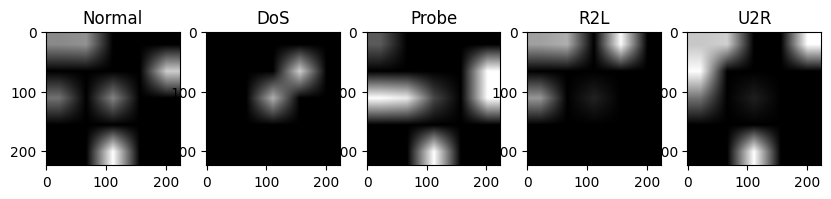

In [46]:
# Read the images for each category, the file name may vary (27.png, 83.png...)
img1 = Image.open('./train_224_NSL-KDD/0/27.png')
img2 = Image.open('./train_224_NSL-KDD/1/83.png')
img3 = Image.open('./train_224_NSL-KDD/2/27.png')
img4 = Image.open('./train_224_NSL-KDD/3/27.png')
img5 = Image.open('./train_224_NSL-KDD/4/92.png')

plt.figure(figsize=(10, 10)) 
plt.subplot(1,5,1)
plt.imshow(img1)
plt.title("Normal")
plt.subplot(1,5,2)
plt.imshow(img2)
plt.title("DoS")
plt.subplot(1,5,3)
plt.imshow(img3)
plt.title("Probe")
plt.subplot(1,5,4)
plt.imshow(img4)
plt.title("R2L")
plt.subplot(1,5,5)
plt.imshow(img5)
plt.title("U2R")
plt.show()  # display it
